# Usage of SymTICA decomposition

The usage of sym_msm package is similar to `TICA` as in deeptime package (https://deeptime-ml.github.io/latest/api/generated/deeptime.decomposition.TICA.html#deeptime.decomposition.TICA)

The main difference is that `SymTICA` results in a reduced number of components, that are constrained by the symmetry of the system.

The other difference is that aside from `transform`, `transform_subunit` is implemented to get the decomposition of each subsystem of the trajectory.

We will use a simple example where the state transition of two identical subsystem are coupled in class `TwoCats`.

In [12]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("ticks")
sns.set_context(font_scale=1.2,context='paper')
sns.set_context({"figure.figsize": (12, 12)})

In [13]:
import pandas as pd
from random import seed
import random as rm
import numpy as np
import pyemma
from pyemma.coordinates import pca
from tqdm.notebook import tqdm  # progress bar
from deeptime.decomposition import TICA

import deeptime
deeptime.__version__

'0.4.4'

In [14]:
from sym_msm.decomposition.sym_tica import SymTICA
from sym_msm.util.dataloader import MultimerTrajectoriesDataset

## Create a toy trajectory

In [15]:
class TwoCats(object):
    """
    A simple two state model with two identical cats with two states each.

    It results in a global state space of 4 states.
    """
    def __init__(self, index):
        """
        Initialize the model with a given index.

        Parameters
        ----------
        index : int
            The index of the model.
        """
        self.index = index
        self._trajectory_states = []
        self._state = self.states[0]
    
    def state_to_features(self):
        if self._state == "CC":
            return np.asarray([0, 0.1, 0.6, 0, 0.1, 0.6])
        elif self._state == "OC":
            return np.asarray([0.9, 0.3, 0.5, 0, 0.1, 0.6])
        elif self._state == "CO":
            return np.asarray([0, 0.1, 0.6, 0.9, 0.3, 0.5])
        elif self._state == "OO":
            return np.asarray([0.9, 0.3, 0.5, 0.9, 0.3, 0.5])
        
        
    def run(self, step):
        self._trajectory = np.zeros([step, 6])
        
        # Init state CC
        self._state = self.states[0]
        self._trajectory_states.append(self.state) 
        self._trajectory[0] = self.state_to_features()
        
        for i in range(1, step):
            if i % 5 == 0:
                self.propagate()
                
            self._trajectory_states.append(self.state) 
            self._trajectory[i] = self.state_to_features()

            
        noise = np.random.normal(0, .01, self._trajectory.shape)
        
        noise[:, 2] += np.random.normal(0, 1, self._trajectory.shape[0])
        noise[:, 5] += np.random.normal(0, 1, self._trajectory.shape[0])
        self._trajectory = self._trajectory + noise
        
    @property
    def state(self):
        return self._state
    
    @property
    def trajectory(self):
        return self._trajectory
    
    @property
    def trajectory_states(self):
        return self._trajectory_states
    
    def propagate(self):
        state_ind = self.states.index(self.state)
        transition = np.random.choice(self.transitionName[state_ind],
                                      replace=True,
                                      p=self.transitionMatrix[state_ind])
        self._state = transition.split('_')[1]
        
    # The statespace
    states = ["CC", "OC","CO", "OO"]
    
    single_states = ["C", "O"]


    # Possible sequences of events
    transitionName = [["CC_CC", "CC_OC", "CC_OC", "CC_OO"],
                      ["CO_CC", "CO_CO", "CO_OC", "CO_OO"],
                      ["OC_CC", "OC_CO", "OC_OC", "OC_OO"],
                      ["OO_CC", "OO_CO", "OO_OC", "OO_OO"]]

    # Probabilities matrix (transition matrix)
    transitionMatrix = [[0.6, 0.2, 0.2, 0.0],
                        [0.3, 0.1, 0.0, 0.6],
                        [0.3, 0.1, 0.0, 0.6],
                        [0.0, 0.1, 0.1, 0.8]]

In [16]:
cat_dimer = TwoCats(index=0)
cat_dimer.run(50000)

data = [cat_dimer.trajectory.astype(np.float32)]
dataset = MultimerTrajectoriesDataset.from_numpy(5, 2, data)

Text(45.41666666666667, 0.5, 'From')

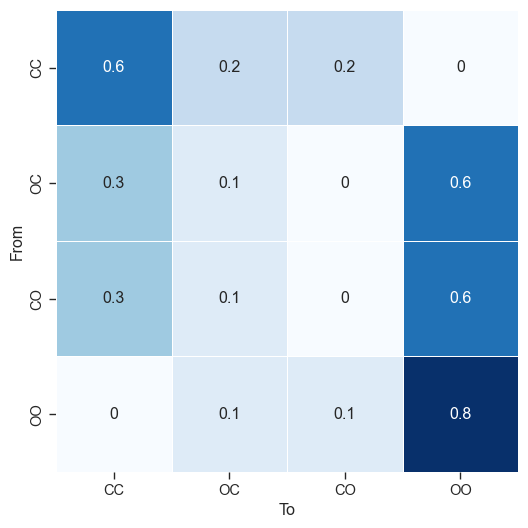

In [17]:
fig, ax = plt.subplots(figsize=(6,6))

sns.heatmap(cat_dimer.transitionMatrix,
            ax=ax,
            xticklabels=cat_dimer.states,
            yticklabels=cat_dimer.states,
            annot=True,
            cmap="Blues",
            cbar=False,
            square=True,
            linewidths=0.5,
            )

ax.set_xlabel("To")
ax.set_ylabel("From")

## Comparison between PCA, TICA and SymTICA

PCA cannot capture the slow dynamics of the system nor the symmetry of the system.

TICA can capture the slow dynamics of the system but not the symmetry of the system.

SymTICA can capture the slow dynamics of the system with reduced number of components. It can also get the decomposition of each subsystem.

In [23]:
pca_model = pca()

pca_model.fit(np.concatenate(dataset.trajectories))

pca_output= [pca_model.transform(traj) for traj in dataset.trajectories]
pca_concatenated= pca_output[0]

/Users/scottzhuang/anaconda3/envs/md_run/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "pca". Called from /Users/scottzhuang/anaconda3/envs/md_run/lib/python3.10/site-packages/decorator.py line 232. Use sklearn.decomposition.PCA instead.
  return caller(func, *(extras + args), **kw)


In [24]:
tica = TICA(var_cutoff=None, lagtime=5)

tica.fit(dataset)

tica_output= [tica.transform(traj) for traj in dataset.trajectories]
tica_concatenated= np.concatenate(tica_output)

tica_model_tica = tica.fetch_model()

In [ ]:
symtica = SymTICA(symmetry_fold=2, var_cutoff=0.8, lagtime=5, scaling=None)
symtica.fit(dataset)
symtica_output= symtica.transform(dataset.trajectories[0])
symtica_concatenated= np.concatenate(symtica_output)

symtica_model_tica = symtica.fetch_model()

symmetry_fold 2


/var/folders/fn/_k4nj2nd6zv85t7_r3417nb40000gn/T/ipykernel_59262/2610728676.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


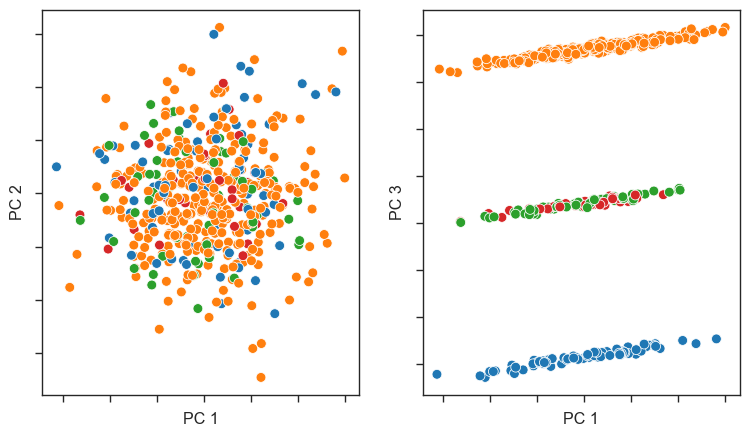

In [25]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, axes = plt.subplots(1,2, figsize=(9,5), sharex=True, gridspec_kw={'hspace': 0.05})
sns.scatterplot(
            x=pca_concatenated[::100, 0],
            y=pca_concatenated[::100, 1],
            hue=cat_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[0], legend=False)
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
# switch legend from CC to sad-sad

sns.scatterplot(
            x=pca_concatenated[::100, 0],
            y=pca_concatenated[::100, 2],
            hue=cat_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=axes[1], legend=False)
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 3")
axes[0].set_xticklabels([])
axes[1].set_xticklabels([])
axes[0].set_yticklabels([])
axes[1].set_yticklabels([])

plt.tight_layout()

/var/folders/fn/_k4nj2nd6zv85t7_r3417nb40000gn/T/ipykernel_59262/3050500970.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


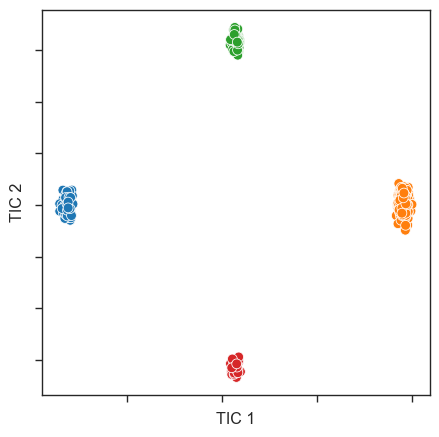

In [55]:
feature = dataset.trajectories[0]
feature_transformed = tica.transform(feature)
fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, gridspec_kw={'hspace': 0.02})
sns.scatterplot(
            x=feature_transformed[::100, 0],
            y=feature_transformed[::100, 1],
            hue=cat_dimer.trajectory_states[::100],
            s=50, alpha=1, ax=ax, legend=False)

ax.set_xlabel("TIC 1")
ax.set_ylabel("TIC 2")
ax.set_xticklabels([])
ax.set_yticklabels([])
# switch legend from CC to sad-sad

plt.tight_layout()

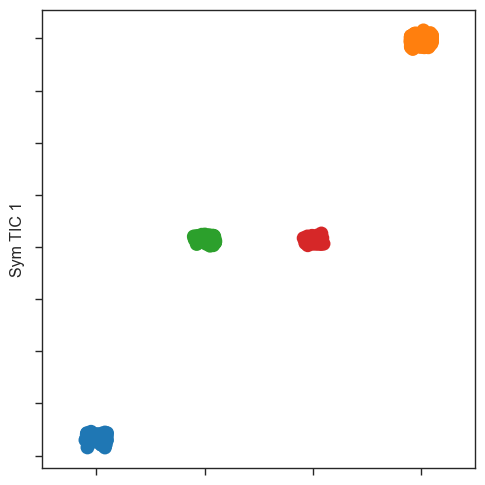

In [28]:
feature = dataset.trajectories[0]
feature_transformed = symtica.transform(feature)
fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(x=cat_dimer.trajectory_states[::100],
              y=feature_transformed[::100, 0],
              hue=cat_dimer.trajectory_states[::100],
              order=cat_dimer.states,
              s=10, alpha=1, ax=ax
              )
ax.set_xlabel("")
ax.set_ylabel("Sym TIC 1")
# hide legend
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.tight_layout()

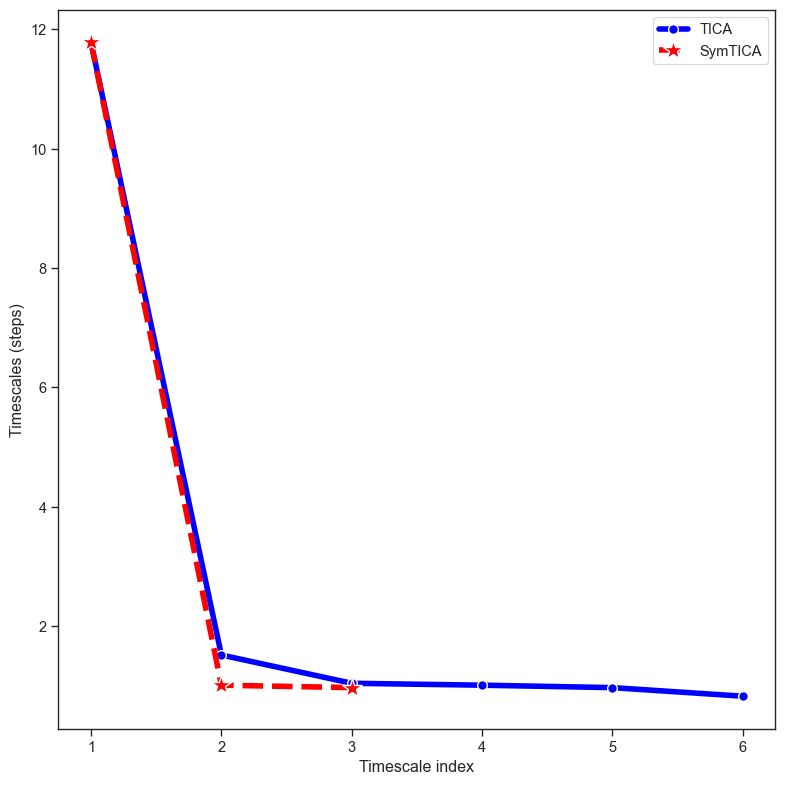

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
n_timescales=100

ax.plot(np.arange(1, tica_model_tica.timescales(k=n_timescales).shape[0]+1),
        tica_model_tica.timescales(k=n_timescales),
             marker='o',
             linestyle='-',
             linewidth=4,
             color='blue',
             markersize=7,
             markeredgecolor='white',
             label='TICA')
ax.plot(np.arange(1, symtica_model_tica.timescales(k=n_timescales).shape[0]+1),
             symtica_model_tica.timescales(k=n_timescales),
             marker='*',
             linestyle='--',
             linewidth=4,
             color='red',
             markersize=15,
             markeredgecolor='white',
            label='SymTICA')


ax.set_ylabel('Timescales (steps)')
ax.set_xlabel('Timescale index')
plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig("assets/dimer_timescales.pdf", dpi=300, transparent=True)

### SymTICA for subsytem decomposition

In [34]:
feature = dataset.trajectories[0]
feature_subsytem_transformed = symtica.transform_subunit(feature)

In [52]:
print(feature_subsytem_transformed.shape)

(50000, 2, 3)


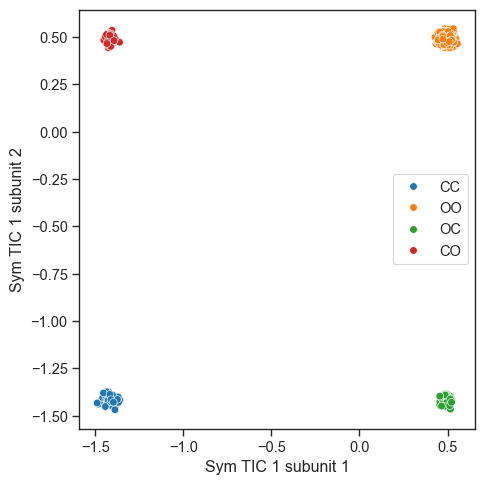

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
sub_1 = feature_subsytem_transformed[::100, 0]
sub_2 = feature_subsytem_transformed[::100, 1]

sns.scatterplot(x=sub_1.T[0],
                y=sub_2.T[0],
                hue=cat_dimer.trajectory_states[::100],
                s=30, alpha=1, ax=ax
              )
ax.set_xlabel("Sym TIC 1 subunit 1")
ax.set_ylabel("Sym TIC 1 subunit 2")
plt.tight_layout()